# **Homework 5 - USA Airport Flight Analysis**

*Group#12*

- **Marco Zimmatore** - [zimmatore.1947442@studenti.uniroma1.it](mailto:zimmatore.1947442@studenti.uniroma1.it)
- **Davide Vitale** - [vitale.1794386@studenti.uniroma1.it](mailto:vitale.1794386@studenti.uniroma1.it)
- **Darkhan Maksutov** - [maksutov.2113209@studenti.uniroma1.it](mailto:maksutov.2113209@studenti.uniroma1.it)
- **Riccardo Soleo** - [soleo.1911063@studenti.uniroma1.it](mailto:soleo.1911063@studenti.uniroma1.it)

___

In [5]:
import functions
import pandas as pd
import numpy as np 
from IPython.display import display, Markdown
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress all warnings
warnings.filterwarnings("ignore")
dataset_path = "data/Airports2.csv"       

In [6]:
df = pd.read_csv(dataset_path)
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140999,-96.670799,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


> We wanna build a graph with edges for each route, where each node represents an airport and eac edge is the existent route between two airports, with all the infos on that route. For this reason, we decide to remove all the rows with *NA* values in them, because each information is crucial for the next exercises computations.

> We remove also all the flights that have $Distance = 0$, because they dont make sense for our next exercises.

In [7]:
df = df.dropna()
df = df[df['Distance'] > 0]
df.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.124599,-123.211998,44.254101,-121.150002
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002
5,MFR,RDM,"Medford, OR","Bend, OR",11,18,1,156,1990-03-01,147300,76034,42.374199,-122.873001,44.254101,-121.150002


> We print the data types of the columns

In [8]:
print(df.shape)
df.dtypes

(3588781, 15)


Origin_airport             object
Destination_airport        object
Origin_city                object
Destination_city           object
Passengers                  int64
Seats                       int64
Flights                     int64
Distance                    int64
Fly_date                   object
Origin_population           int64
Destination_population      int64
Org_airport_lat           float64
Org_airport_long          float64
Dest_airport_lat          float64
Dest_airport_long         float64
dtype: object

> Before storing the dataframe into a Graph, we wanna decide if the graph has to be directed or undirected. For this reason we compute the number of *Bidirectional* routes compared to the number of *Unidirectional* routes. 



In [9]:
# Create a copy of the dataframe
df_undirected_edges = df[['Origin_airport', 'Destination_airport']].copy()

# Create a normalized key to represent bidirectional routes
df_undirected_edges['normalized_key'] = df.apply(
    lambda row: tuple(sorted([row['Origin_airport'], row['Destination_airport']])), axis=1
)

# Add a column to represent the actual direction of the route
df_undirected_edges['direction'] = df.apply(
    lambda row: (row['Origin_airport'], row['Destination_airport']), axis=1
)

# Add a column to represent the reverse direction of the route
df_undirected_edges['reverse_direction'] = df.apply(
    lambda row: (row['Destination_airport'], row['Origin_airport']), axis=1
)

# Group by normalized_key and collect all directions and reverse directions
grouped_undirected = df_undirected_edges.groupby('normalized_key').agg(
    directions=('direction', list),  # List of all actual directions
    reverse_directions=('reverse_direction', list)  # List of all reverse directions
).reset_index()

# Check if both directions exist for each route
grouped_undirected['is_bidirectional'] = grouped_undirected.apply(
    lambda row: 1 if any(d in row['reverse_directions'] for d in row['directions']) else 0, axis=1
)
# We compute the Percentage between bidirectional and unidirectiona routes
grouped_undirected['is_bidirectional'].value_counts() * 100 / grouped_undirected.shape[0]

is_bidirectional
1    60.557028
0    39.442972
Name: count, dtype: float64

> Since the Number of Bidirectional routes is not too high compared to the Unidirectional Routes, we can proceed using a **Directed Graph** module in *NetworkX*.
___

## **Flight Network Analysis (Q1)**
___

Before going deep in the exercises, we store the Dataframe in a Graph.

**Function** `create_airport_graph`

- The function `create_airport_graph(df)` creates a directed graph using the **Networkx** library from a DataFrame containing airports and flight data.

- For the reasons explained above, we decide to use a **DiGraph** structure because we want to store only 2 connections per route at max. 

- For each row in the DataFrame, it adds two nodes (representing the origin and destination airports) to the graph, along with attributes such as city, population, latitude, and longitude.

-  It then adds a directed edge between the origin and destination airports, with attributes like the number of passengers, flights, seats, **weight as distance**, and flight date.

In [10]:
graph = functions.create_airport_graph(df)
print(graph)

DiGraph with 483 nodes and 34531 edges


> We can notice that only a subset of all the connections have been stored, since the *NetworkX* *DiGraph* structure allows only two edges per route at max.

**Remark**: all the functions displayed and explained below in the $Q_1$, will be runned in the last section (to generate the report), in order to be tidier and not to be too verbose, so that the report can be understood without ripetitions.
___

1. Implement a function `analyze_graph_features(flight_network)` that takes the flight network as input and computes the following:

    - Count the number of airports (`nodes`) and flights (`edges`) in the graph.

    - Compute the density of the graph using the formula: $ Density = \frac{2\times E}{N(N − 1)}$

    - Calculate both `in-degree` and `out-degree` for each airport and visualize them using histograms.

    - Identify airports with degrees higher than the 90th percentile and list them as "`hubs`".
    
    - Determine if the graph is sparse or dense based on its density.



**Function** `analyze_graph_features(flight_network)` 

- It counts the total number of nodes (airports) and edges (flight routes) in the graph iterating over the number of the nodes and the edges to calculate the *in-degrees* and *out_degrees* of each node and storing them into a dictionary.

- It calculates the graph density, which is the ratio of the actual number of edges to the maximum possible number of edges in a directed graph with the same number of nodes. Since we are using a **Directed Graph** the formula used is: $$Density = \frac{\text{Number of Edges}}{\text{Number of nodes} \times (\text{Number of nodes} - 1)}$$ 

- Then we create two Histograms using **Plotly**, one for *in-degrees* and one for *out-degrees*

- It calculates the 90th percentile of the total degree (sum of in-degree and out-degree) across all nodes. Nodes that have a degree higher than this percentile are considered "**hubs**" (highly connected airports).

- In the end, it checks whether the graph is dense or sparse based on the calculated graph density. If the density is greater than a threshold (0.5), the graph is considered dense, otherwise it is sparse.
​


In [7]:
def analyze_graph_features(flight_network):
    # Initialize variables to store the number of nodes and edges
    number_of_nodes = 0
    number_of_edges = len(flight_network.edges())  # Count the number of edges in the graph
    dict_degrees_edges = dict()  # Create an empty dictionary to store in-degrees and out-degrees for each node

    # Iterate over each node in the flight network
    for node in flight_network.nodes:
        number_of_nodes = number_of_nodes + 1  # Increment the node count

        in_edges = 0  # Initialize in-degree counter
        out_edges = 0  # Initialize out-degree counter

        # Count the outgoing edges from the current node
        for _, _, attr in flight_network.edges(node, data=True):
            out_edges += 1

        # Count the incoming edges to the current node
        for _, _, attr in flight_network.in_edges(node, data=True):
            in_edges += 1

        # Store the in-degree and out-degree for the current node in the dictionary
        dict_degrees_edges[node] = [in_edges, out_edges]

    # Calculate graph density using the formula
    graph_density = (number_of_edges) / (number_of_nodes * (number_of_nodes - 1))

    # Extract the in-degrees and out-degrees from the dictionary for histogram plotting
    in_degrees = [edge_degree[0] for edge_degree in dict_degrees_edges.values()]
    out_degrees = [edge_degree[1] for edge_degree in dict_degrees_edges.values()]

    # Create a subplot with 1 row and 2 columns to display histograms for in-degrees and out-degrees
    fig = make_subplots(rows=1, cols=2, subplot_titles=('In-degree Histogram', 'Out-degree Histogram'))

    # Add in-degree histogram to the first subplot (left)
    fig.add_trace(
        go.Histogram(x=in_degrees, nbinsx=20, name='In-degree', marker=dict(color='steelblue')),
        row=1, col=1
    )

    # Add out-degree histogram to the second subplot (right)
    fig.add_trace(
        go.Histogram(x=out_degrees, nbinsx=20, name='Out-degree', marker=dict(color='darkorange')),
        row=1, col=2
    )

    # Update layout for better aesthetics
    fig.update_layout(
        title="In-degree vs Out-degree Histograms",  # Set the title of the plot
        xaxis_title="Degree",  # Label for x-axis
        yaxis_title="Frequency",  # Label for y-axis
        showlegend=True,  # Display legend
        height=500,  # Adjust the height of the figure
        width=1000   # Adjust the width of the figure
    )

    # Calculate the 90th percentile for the total degrees (in-degree + out-degree) of each node

    # Build a dictionary to compute the total degree value (in-degree + out-degree) for each node
    dict_degrees = dict()

    # Iterate over the nodes and calculate the total degree for each
    for node, degrees in dict_degrees_edges.items():
        dict_degrees[node] = degrees[0] + degrees[1]  # Sum in-degree and out-degree for each node

    # Use numpy's percentile function to get the 90th percentile of the degrees
    degree_percentile = np.percentile(list(dict_degrees.values()), 90)

    # Identify nodes (airports) that are "hubs", meaning their total degree is greater than the 90th percentile
    hubs = []

    # Iterate over the nodes and check if their total degree exceeds the 90th percentile
    for node, degree in dict_degrees.items():
        if degree > degree_percentile:
            hubs.append((node, degree))  # Add the node and its degree to the list of hubs

    threshold = 0.5  # Set a threshold to decide if the graph is dense or sparse

    # Check if the graph is dense or sparse based on the density calculated earlier
    if graph_density > threshold:
        is_sparse = False  # If the density is greater than the threshold, the graph is considered dense
    else:
        is_sparse = True  # Otherwise, the graph is considered sparse

    # Return the number of nodes, the number of edges, the figure with histograms, the list of hubs, and whether the graph is sparse
    return number_of_nodes, number_of_edges, fig, hubs, is_sparse


2. Write a function `summarize_graph_features(flight_network)` that generates a detailed report of the graph's features. A summary report needs to include:

    - The number of nodes and edges.
    
    - The graph density.
    
    - Degree distribution plots for in-degree and out-degree.
    
    - A table of identified hubs.



**Function** `summarize_graph_features(flight_network)`


The `summarize_graph_features(flight_network)` function analyzes the features of a flight network graph and generates a summary of the graph's properties:

- **Analyzes Graph Features**: It uses the `analyze_graph_features` function to compute key metrics of the flight network, we have described above

- **Creates a Summary Table**: The function generates a markdown table summarizing the following metrics:

    - **Number of airports**

    - **Number of flights** 

    - **Graph density**

    - **Graph classification** (whether the graph is sparse or dense)

- **Displays Hubs**: It creates and displays a table of identified "*hubs*" listing the airports with the highest degree in the network, alongside their degree values (number of connections).

- **Displays Degree Distribution**: The function also visualizes and displays the degree distribution histogram, which shows the distribution of in-degrees and out-degrees across the airports (nodes) in the network

In [8]:
def summarize_graph_features(flight_network):
    # Analyze graph features
    number_of_nodes, number_of_edges, degree_histogram, hubs, is_sparse = analyze_graph_features(flight_network)

    # Create a textual summary
    density_description = "dense" if not is_sparse else "sparse"
    summary_table = f"""
| Metric                  | Value                      |
|-------------------------|----------------------------|
| **Number of Airports**      | {number_of_nodes}          |
| **Number of Flights**       | {number_of_edges}          |
| **Graph Density**           | {'{:.4f}'.format((2 * number_of_edges) / (number_of_nodes * (number_of_nodes - 1)))}|
| **Graph Classification**    | {density_description.capitalize()} |
"""

    row_labels = "| Hubs (Airports)          | " + " | ".join([hub[0] for hub in hubs]) + " |\n"
    separator_row = "|-----------------| " + " | ".join(["---"] * len(hubs)) + " |\n"
    # Create the degree row
    degree_row = "| **Degrees**          | " + " | ".join([str(hub[1]) for hub in hubs]) + " |\n"

    # Combine rows into the Markdown table
    hubs_table = row_labels + separator_row + degree_row

    display(Markdown("## **Graph Features Summary**"))

    # Display summary
    display(Markdown(summary_table))

    display(Markdown("### **Identified Hubs**"))
    # Display the hubs table
    display(Markdown(hubs_table))

    # Display the degree distribution histogram
    display(Markdown("### **Degree Distribution**"))
    degree_histogram.show()



3. Now let's dive deeper into the analysis of the dataset. Do the following:
    
    - Compute total passenger flow between origin and destination cities.

    - Identify and visualize the busiest routes by passenger traffic.

    - Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

    - Create an interactive map visualizing the geographic spread of the flight network.

> We split the workload of this exercise in two functions: `analysis_traffic_passengers(df)` and  `create_interactive_map(df)`

**Function**  `analysis_traffic_passengers(df)`

The `analysis_traffic_passengers` function analyzes passenger traffic data for flight routes and generates several outputs to help understand the busiest routes, average passengers per route, and least traveled routes:

-  The function takes in a *DataFrame* containing flight data and an optional parameter, `number_of_busiest_routes` (default set to 10), to define how many routes to display. 

- **Busiest Routes** (by Total Passengers):

    - The data is grouped by origin and destination airports, and the total number of passengers per route is calculated.

    - The routes are sorted by total passengers in descending order, and the top `number_of_busiest_routes` routes are selected.
    
    - A new column, `Route`, is created by combining the origin and destination airports for easy display.

    - A Plotly bar plot is generated to visualize the busiest routes with the total number of passengers.

- **Average Traffic Per Route**:

    - The function calculates the average number of passengers per route by grouping the data by origin and destination airports.

    - The routes are sorted by average passengers in descending order to identify the busiest routes in terms of average passengers.

    - Similarly, the routes with the least average passengers are sorted in ascending order.



In [9]:
df_sorted_passengers, fig, df_most_traffic, df_least_traffic = functions.analysis_traffic_passengers(df) 
fig.show()


> We can notice that most of the busiest routes connect the major American cities to *Honolulu* (Hawaii) underlining that in the last 30 years, Hawaii has been the most loved place to go on vacation by American citizens

**Function** `create_interactive_map(df)`

The `create_interactive_map` function generates an interactive map using *Folium* to visualize flight routes and airports. 

- It initializes a map centered on the US.

- Filters the dataset to select only the Busiest flights based on the number of passenger, because we want to draw only one connection per route's direction. So birectional routes will have two *PolyLines* that connect he airports.

- It adds flight conections as *Folium* **PolyLines** (lines connecting origin and destination airports).

- Adds *Folium* markers for each airport, displaying airport names and cities when clicked.

- Saves the map as an HTML file for interactive exploration.

In [10]:
functions.create_interactive_map(df)

Saved map as 'flight_network_map.html'.


4. Once you have created and tested the previous functions, the results should be presented in a tidy way. Your summary report should contain:

- The number of nodes and edges.

-    The graph density.

-    Degree distribution plots for in-degree and out-degree.

-    A table of identified hubs.

-    Top routes by passenger flow (table and bar chart).

-    Top routes by passenger efficiency (table and bar chart).

-    An interactive map showing flight routes.


**Function** `generate_report(df, graph)`

The `generate_report` function generates a detailed report on the flight network, including the following:

- **Graph Features Summary**: Summarizes the features of the flight network calling the function `summarize_graph_features`.

- **Traffic Analysis**: Displays the busiest routes by passenger flow, the most and least trafficked routes calling the function `analysis_traffic_passengers`

- **Under-Utilized and Over-Utilized Routes**: Shows routes with the least and most passenger traffic.

- **Top Routes by Passenger Efficiency**:

    - It calculates and displays the most efficient routes (Top 10) with a corresponding bar chart. In our interpretation, *Passenger Efficiency* is the number of Passengers transported per Km for each route.

    - We have computed the **Passenger Efficiency** as 
$$ \text{Passenger Efficiency} = \frac{\text{Average Number of Passengers of that Route}}{\text{Route Distance}}$$


**Remark**: we have included the interactive map in the *flight_network_map.html* file saved by the function `create_interactive_map` 

In [11]:
functions.generate_report(df, graph)

## **Graph Features Summary**


| Metric                  | Value                      |
|-------------------------|----------------------------|
| **Number of Airports (Nodes)**      | 483          |
| **Number of Flights (Edges)**       | 34531          |
| **Graph Density**           | 0.2967|
| **Graph Classification**    | Sparse |


### **Identified Hubs**

| Hubs (Airports)          | SEA | SFO | LAX | FLL | PHX | TUS | DFW | SLC | LAS | ICT | OKC | IAH | ELP | TUL | OMA | RFD | MKE | LIT | SHV | MCI | SAT | MSP | ORD | STL | BNA | MEM | IND | CLE | DTW | DAY | CVG | CMH | PIT | BOS | ATL | MDW | PHL | EWR | CLT | JFK | YIP | MCO | IAD | MSY | RDU | BWI | TYS | MIA | DAL |
|-----------------| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Degrees**          | 390 | 366 | 435 | 374 | 474 | 415 | 494 | 457 | 461 | 384 | 453 | 437 | 389 | 365 | 383 | 381 | 451 | 402 | 401 | 496 | 382 | 566 | 512 | 499 | 428 | 523 | 496 | 427 | 455 | 373 | 436 | 395 | 433 | 385 | 509 | 406 | 421 | 422 | 410 | 404 | 541 | 409 | 467 | 385 | 407 | 439 | 382 | 479 | 382 |


### **Degree Distribution**

### **Top Routes by Passenger Flow**

Origin_airport,Destination_airport,Total_Passengers
OGG,HNL,32364612
HNL,OGG,29744742
LAX,HNL,28964154
HNL,LAX,28632161
LAS,LAX,26333721
LAX,LAS,26177809
LAX,SFO,25661782
SFO,LAX,25458207
ATL,MCO,23483751
ORD,LAX,22979359


### **Under-Utilized Routes**

Origin_airport,Destination_airport,Average_Passengers
ABE,ACT,0.0
IDA,SGU,0.0
ILG,ABE,0.0
ILG,ADS,0.0
ILG,BDL,0.0
ILG,BIF,0.0
ILG,BNA,0.0
ILG,BRO,0.0
ILG,BUF,0.0
ILG,CAK,0.0


### **Over-Utilized Routes**

Origin_airport,Destination_airport,Average_Passengers
DAL,HOU,21828.4
HOU,DAL,21686.0
LGA,DCA,15371.6
DCA,LGA,14628.6
HNL,OGG,14043.8
BOS,LGA,13865.1
LGA,BOS,13674.9
OGG,HNL,13490.9
OAK,JFK,12615.6
HOU,MSY,11942.8


### **Top Routes by Passenger Efficiency**

Origin_airport,Destination_airport,Passenger_Efficiency
HNL,OGG,140.4
OGG,HNL,134.9
DAL,HOU,91.3
HOU,DAL,90.7
BOS,LGA,74.9
LGA,BOS,73.9
LGA,DCA,71.8
DCA,LGA,68.4
IAH,EFD,49.7
DAL,AUS,46.5


____
After completing the analysis, answer the following questions:



- Is the graph sparse or dense?


> Since the density of the graph is quite near 0, we can assume that the graph is **sparse**.

-  What patterns do you observe in the degree distribution?


> Both Histograms of *out_degree* and *in_degree* of each edge assume similar distributions: most of the nodes tend to be have 20 or less number of edges, another slice of nodes have in and out degrees between 20 and 100.  

- Which airports are identified as hubs, and why?


| Hubs (Airports)          | SEA | SFO | LAX | FLL | PHX | TUS | DFW | SLC | LAS | ICT | OKC | IAH | ELP | TUL | OMA | RFD | MKE | LIT | SHV | MCI | SAT | MSP | ORD | STL | BNA | MEM | IND | CLE | DTW | DAY | CVG | CMH | PIT | BOS | ATL | MDW | PHL | EWR | CLT | JFK | YIP | MCO | IAD | MSY | RDU | BWI | TYS | MIA | DAL |
|-----------------| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| **Degrees**          | 392 | 368 | 437 | 376 | 476 | 417 | 496 | 459 | 463 | 386 | 455 | 439 | 391 | 367 | 383 | 383 | 453 | 404 | 403 | 498 | 384 | 568 | 514 | 501 | 430 | 525 | 498 | 429 | 457 | 375 | 438 | 397 | 435 | 387 | 511 | 408 | 423 | 424 | 412 | 406 | 543 | 411 | 469 | 387 | 409 | 441 | 384 | 481 | 384 |

<br>

> These airports are listed as '*hubs*' because their degree is higher than 90% of the degree of all the nodes

- What are the busiest routes in terms of passenger traffic?


<style type="text/css">
</style>
<table id="T_c0f38">
  <thead>
    <tr>
      <th id="T_c0f38_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_c0f38_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_c0f38_level0_col2" class="col_heading level0 col2" >Total_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_c0f38_row0_col0" class="data row0 col0" >OGG</td>
      <td id="T_c0f38_row0_col1" class="data row0 col1" >HNL</td>
      <td id="T_c0f38_row0_col2" class="data row0 col2" >32364612</td>
    </tr>
    <tr>
      <td id="T_c0f38_row1_col0" class="data row1 col0" >HNL</td>
      <td id="T_c0f38_row1_col1" class="data row1 col1" >OGG</td>
      <td id="T_c0f38_row1_col2" class="data row1 col2" >29744742</td>
    </tr>
    <tr>
      <td id="T_c0f38_row2_col0" class="data row2 col0" >LAX</td>
      <td id="T_c0f38_row2_col1" class="data row2 col1" >HNL</td>
      <td id="T_c0f38_row2_col2" class="data row2 col2" >28964154</td>
    </tr>
    <tr>
      <td id="T_c0f38_row3_col0" class="data row3 col0" >HNL</td>
      <td id="T_c0f38_row3_col1" class="data row3 col1" >LAX</td>
      <td id="T_c0f38_row3_col2" class="data row3 col2" >28632161</td>
    </tr>
    <tr>
      <td id="T_c0f38_row4_col0" class="data row4 col0" >LAS</td>
      <td id="T_c0f38_row4_col1" class="data row4 col1" >LAX</td>
      <td id="T_c0f38_row4_col2" class="data row4 col2" >26333721</td>
    </tr>
    <tr>
      <td id="T_c0f38_row5_col0" class="data row5 col0" >LAX</td>
      <td id="T_c0f38_row5_col1" class="data row5 col1" >LAS</td>
      <td id="T_c0f38_row5_col2" class="data row5 col2" >26177809</td>
    </tr>
    <tr>
      <td id="T_c0f38_row6_col0" class="data row6 col0" >LAX</td>
      <td id="T_c0f38_row6_col1" class="data row6 col1" >SFO</td>
      <td id="T_c0f38_row6_col2" class="data row6 col2" >25661782</td>
    </tr>
    <tr>
      <td id="T_c0f38_row7_col0" class="data row7 col0" >SFO</td>
      <td id="T_c0f38_row7_col1" class="data row7 col1" >LAX</td>
      <td id="T_c0f38_row7_col2" class="data row7 col2" >25458207</td>
    </tr>
    <tr>
      <td id="T_c0f38_row8_col0" class="data row8 col0" >ATL</td>
      <td id="T_c0f38_row8_col1" class="data row8 col1" >MCO</td>
      <td id="T_c0f38_row8_col2" class="data row8 col2" >23483751</td>
    </tr>
    <tr>
      <td id="T_c0f38_row9_col0" class="data row9 col0" >ORD</td>
      <td id="T_c0f38_row9_col1" class="data row9 col1" >LAX</td>
      <td id="T_c0f38_row9_col2" class="data row9 col2" >22979359</td>
    </tr>
  </tbody>
</table>
<br>

> These routes represent the 10 highest traffic connections, highlighting the demand for travel between major airports, especially in regions like California and Hawaii.


- Which routes are under/over-utilized?


##### **Under-Utilized Routes**

<style type="text/css">
</style>
<table id="T_c15c7">
  <thead>
    <tr>
      <th id="T_c15c7_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_c15c7_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_c15c7_level0_col2" class="col_heading level0 col2" >Average_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_c15c7_row0_col0" class="data row0 col0" >ABE</td>
      <td id="T_c15c7_row0_col1" class="data row0 col1" >ACT</td>
      <td id="T_c15c7_row0_col2" class="data row0 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row1_col0" class="data row1 col0" >IDA</td>
      <td id="T_c15c7_row1_col1" class="data row1 col1" >SGU</td>
      <td id="T_c15c7_row1_col2" class="data row1 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row2_col0" class="data row2 col0" >ILG</td>
      <td id="T_c15c7_row2_col1" class="data row2 col1" >ABE</td>
      <td id="T_c15c7_row2_col2" class="data row2 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row3_col0" class="data row3 col0" >ILG</td>
      <td id="T_c15c7_row3_col1" class="data row3 col1" >ADS</td>
      <td id="T_c15c7_row3_col2" class="data row3 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row4_col0" class="data row4 col0" >ILG</td>
      <td id="T_c15c7_row4_col1" class="data row4 col1" >BDL</td>
      <td id="T_c15c7_row4_col2" class="data row4 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row5_col0" class="data row5 col0" >ILG</td>
      <td id="T_c15c7_row5_col1" class="data row5 col1" >BIF</td>
      <td id="T_c15c7_row5_col2" class="data row5 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row6_col0" class="data row6 col0" >ILG</td>
      <td id="T_c15c7_row6_col1" class="data row6 col1" >BNA</td>
      <td id="T_c15c7_row6_col2" class="data row6 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row7_col0" class="data row7 col0" >ILG</td>
      <td id="T_c15c7_row7_col1" class="data row7 col1" >BRO</td>
      <td id="T_c15c7_row7_col2" class="data row7 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row8_col0" class="data row8 col0" >ILG</td>
      <td id="T_c15c7_row8_col1" class="data row8 col1" >BUF</td>
      <td id="T_c15c7_row8_col2" class="data row8 col2" >0.0</td>
    </tr>
    <tr>
      <td id="T_c15c7_row9_col0" class="data row9 col0" >ILG</td>
      <td id="T_c15c7_row9_col1" class="data row9 col1" >CAK</td>
      <td id="T_c15c7_row9_col2" class="data row9 col2" >0.0</td>
    </tr>
  </tbody>
</table>

<br>

> These routes are under-utilized considering the assumption that we have not considered routes that have no *Distance*, with no passengers recorded on average. This may indicate low demand or possibly infrequent flights, which could suggest an opportunity for route optimization or better marketing strategies to increase passenger traffic.


##### **Over-Utilized Routes**

<style type="text/css">
</style>
<table id="T_fc661">
  <thead>
    <tr>
      <th id="T_fc661_level0_col0" class="col_heading level0 col0" >Origin_airport</th>
      <th id="T_fc661_level0_col1" class="col_heading level0 col1" >Destination_airport</th>
      <th id="T_fc661_level0_col2" class="col_heading level0 col2" >Average_Passengers</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td id="T_fc661_row0_col0" class="data row0 col0" >DAL</td>
      <td id="T_fc661_row0_col1" class="data row0 col1" >HOU</td>
      <td id="T_fc661_row0_col2" class="data row0 col2" >21828.4</td>
    </tr>
    <tr>
      <td id="T_fc661_row1_col0" class="data row1 col0" >HOU</td>
      <td id="T_fc661_row1_col1" class="data row1 col1" >DAL</td>
      <td id="T_fc661_row1_col2" class="data row1 col2" >21686.0</td>
    </tr>
    <tr>
      <td id="T_fc661_row2_col0" class="data row2 col0" >LGA</td>
      <td id="T_fc661_row2_col1" class="data row2 col1" >DCA</td>
      <td id="T_fc661_row2_col2" class="data row2 col2" >15371.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row3_col0" class="data row3 col0" >DCA</td>
      <td id="T_fc661_row3_col1" class="data row3 col1" >LGA</td>
      <td id="T_fc661_row3_col2" class="data row3 col2" >14628.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row4_col0" class="data row4 col0" >HNL</td>
      <td id="T_fc661_row4_col1" class="data row4 col1" >OGG</td>
      <td id="T_fc661_row4_col2" class="data row4 col2" >14043.8</td>
    </tr>
    <tr>
      <td id="T_fc661_row5_col0" class="data row5 col0" >BOS</td>
      <td id="T_fc661_row5_col1" class="data row5 col1" >LGA</td>
      <td id="T_fc661_row5_col2" class="data row5 col2" >13865.1</td>
    </tr>
    <tr>
      <td id="T_fc661_row6_col0" class="data row6 col0" >LGA</td>
      <td id="T_fc661_row6_col1" class="data row6 col1" >BOS</td>
      <td id="T_fc661_row6_col2" class="data row6 col2" >13674.9</td>
    </tr>
    <tr>
      <td id="T_fc661_row7_col0" class="data row7 col0" >OGG</td>
      <td id="T_fc661_row7_col1" class="data row7 col1" >HNL</td>
      <td id="T_fc661_row7_col2" class="data row7 col2" >13490.9</td>
    </tr>
    <tr>
      <td id="T_fc661_row8_col0" class="data row8 col0" >OAK</td>
      <td id="T_fc661_row8_col1" class="data row8 col1" >JFK</td>
      <td id="T_fc661_row8_col2" class="data row8 col2" >12615.6</td>
    </tr>
    <tr>
      <td id="T_fc661_row9_col0" class="data row9 col0" >HOU</td>
      <td id="T_fc661_row9_col1" class="data row9 col1" >MSY</td>
      <td id="T_fc661_row9_col2" class="data row9 col2" >11942.8</td>
    </tr>
  </tbody>
</table>
<br>

> These routes are characterized by high passenger traffic, indicating strong demand, such as *Dallas to Houston* and *Houston to Dallas* that the ones with the highest average.
____

## **Nodes' Contribution (Q2)**

1. Implement a function `analyze_centrality(flight_network, airport)` that computes the following centrality measures for a given airport:


    - *Betweenness* *centrality*: Measures how often a node appears on the shortest paths between other nodes.
    
    - *Closeness* *centrality*: Measures how easily a node can access all other nodes in the network.
    
    - *Degree* *centrality*: Simply counts the number of direct connections to the node.
    
    - *PageRank*: Computes the "importance" of a node based on incoming connections and their weights.


In [12]:
df['weight'] = 1

# Aggregare i dati per sommare i pesi (numero di voli tra le coppie di aeroporti)
aggregated_df = df.groupby(['Origin_airport', 'Destination_airport'], as_index=False).agg({'weight': 'sum'})

# Creare la lista unica di aeroporti
airports = pd.concat([df['Origin_airport'], df['Destination_airport']]).unique()

# Creare il dizionario edges
edges = {
    (row['Origin_airport'], row['Destination_airport']): row['weight']
    for _, row in aggregated_df.iterrows()
}

# Mappare gli aeroporti agli indici
airport_to_idx = {airport: idx for idx, airport in enumerate(airports)}

# Creare la matrice di adiacenza
n = len(airports)
adjacency_matrix = np.zeros((n, n), dtype=float)

# Riempire la matrice di adiacenza usando il dizionario edges
for (source, target), weight in edges.items():
    i = airport_to_idx[source]
    j = airport_to_idx[target]
    adjacency_matrix[i, j] = weight


In [19]:
from functions import betweenness_centrality, closeness_centrality ,degree_centrality, pagerank
import matplotlib.pyplot as plt
import networkx as nx

In [16]:
def analyze_centrality(flight_network, airport):
    if airport not in flight_network:
        raise ValueError(f"Airport '{airport}' not found in the flight network.")
    
    # Compute centralities for all nodes
    betweenness = betweenness_centrality(flight_network)
    closeness = closeness_centrality(flight_network)
    degree = degree_centrality(flight_network)
    pagerank_scores = pagerank(flight_network)

    # Extract values for the specified airport
    return {
        "betweenness": betweenness.get(airport, 0.0),
        "closeness": closeness.get(airport, 0.0),
        "degree": degree.get(airport, 0.0),
        "pagerank": pagerank_scores.get(airport, 0.0)
    }


In [21]:
flight_network = nx.to_dict_of_lists(graph)
result = analyze_centrality(flight_network, "OGG")
resultt = pd.DataFrame.from_dict(result, orient="index", columns=["Centrality"])
resultt.reset_index(inplace=True)
resultt.columns = ["Measure", "Value"]

# Convert DataFrame to Markdown
markdown_table = resultt.to_markdown(index=False)
display(Markdown(markdown_table))

| Measure     |       Value |
|:------------|------------:|
| betweenness | 12.0196     |
| closeness   |  0.503132   |
| degree      |  0.0788382  |
| pagerank    |  0.00126066 |

`betweenness=12` $\rightarrow$ This value indicates that the airport "OGG" plays a significant role in connecting different nodes (airports) in the network

`closeness=0.5` $\rightarrow$ closeness centrality measures how quickly "OGG" can reach all other airports in the networw, a value of 0.503132 suggests that "OGG" has moderate accessibility within the network.

`degree=0.079` $\rightarrow$ A value of 0.0788382 means that "OGG" is directly connected to about 7.88% of all airports in the network.

`pagerank=0.00126` $\rightarrow$ PageRank measures the "importance" of OGG based on its connections and the importance of the nodes it's connected to. A value of 0.00126066 is low, suggesting that "OGG" is not highly influential in terms of the overall connectivity of the network.

2.  Write a function `compare_centralities(flight_network)` to:

    - Compute and compare centrality values for all nodes in the graph.
    
    - Plot centrality distributions (histograms for each centrality measure).
    
    - Return the top 5 airports for each centrality measure.



In [31]:
def compare_centralities(flight_network):
    """
    Computes centralities (Degree, Closeness, Betweenness, PageRank) on a flight network.
    If the input is a NetworkX DiGraph, it is first converted to a dict-of-lists adjacency.
    Plots histograms of each centrality measure and returns the top 5 airports per measure.
    """
    #convert to a dictionary of adjacency lists
    if isinstance(flight_network, (nx.Graph, nx.DiGraph)):
        flight_network = nx.to_dict_of_lists(flight_network)

    # calculate centrality 
    degree_centr = degree_centrality(flight_network)
    closeness_centr = closeness_centrality(flight_network)
    betweenness_centr = betweenness_centrality(flight_network)
    pagerank2 = pagerank(flight_network)

    #build a pandas DataFrame for comparison
    centrality_df = pd.DataFrame({
        'Airport': list(degree_centr.keys()),
        'Degree Centrality': list(degree_centr.values()),
        'Closeness Centrality': [closeness_centr[node] for node in degree_centr],
        'Betweenness Centrality': [betweenness_centr[node] for node in degree_centr],
        'PageRank': [pagerank2[node] for node in degree_centr]
    })

    #plot histograms of each centrality measure
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Centrality Distributions for Airports", fontsize=16)

    centrality_df['Degree Centrality'].hist(ax=axes[0, 0], bins=50, color='skyblue')
    axes[0, 0].set_title("Degree Centrality Distribution")
    axes[0, 0].set_xlabel("Degree Centrality")
    axes[0, 0].set_ylabel("Frequency")

    centrality_df['Closeness Centrality'].hist(ax=axes[0, 1], bins=50, color='lightgreen')
    axes[0, 1].set_title("Closeness Centrality Distribution")
    axes[0, 1].set_xlabel("Closeness Centrality")
    axes[0, 1].set_ylabel("Frequency")

    centrality_df['Betweenness Centrality'].hist(ax=axes[1, 0], bins=50, color='lightcoral')
    axes[1, 0].set_title("Betweenness Centrality Distribution")
    axes[1, 0].set_xlabel("Betweenness Centrality")
    axes[1, 0].set_ylabel("Frequency")

    centrality_df['PageRank'].hist(ax=axes[1, 1], bins=50, color='gold')
    axes[1, 1].set_title("PageRank Distribution")
    axes[1, 1].set_xlabel("PageRank")
    axes[1, 1].set_ylabel("Frequency")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # 5) Return the top 5 airports by each centrality
    top_airports = {
        'Top Degree Centrality': centrality_df.nlargest(5, 'Degree Centrality')[['Airport', 'Degree Centrality']],
        'Top Closeness Centrality': centrality_df.nlargest(5, 'Closeness Centrality')[['Airport', 'Closeness Centrality']],
        'Top Betweenness Centrality': centrality_df.nlargest(5, 'Betweenness Centrality')[['Airport', 'Betweenness Centrality']],
        'Top PageRank': centrality_df.nlargest(5, 'PageRank')[['Airport', 'PageRank']]
    }
    for key, result_df in top_airports.items():
        markdown_table = result_df.to_markdown(index=False)
        display(Markdown(f"### {key}\n\n{markdown_table}"))

    return 

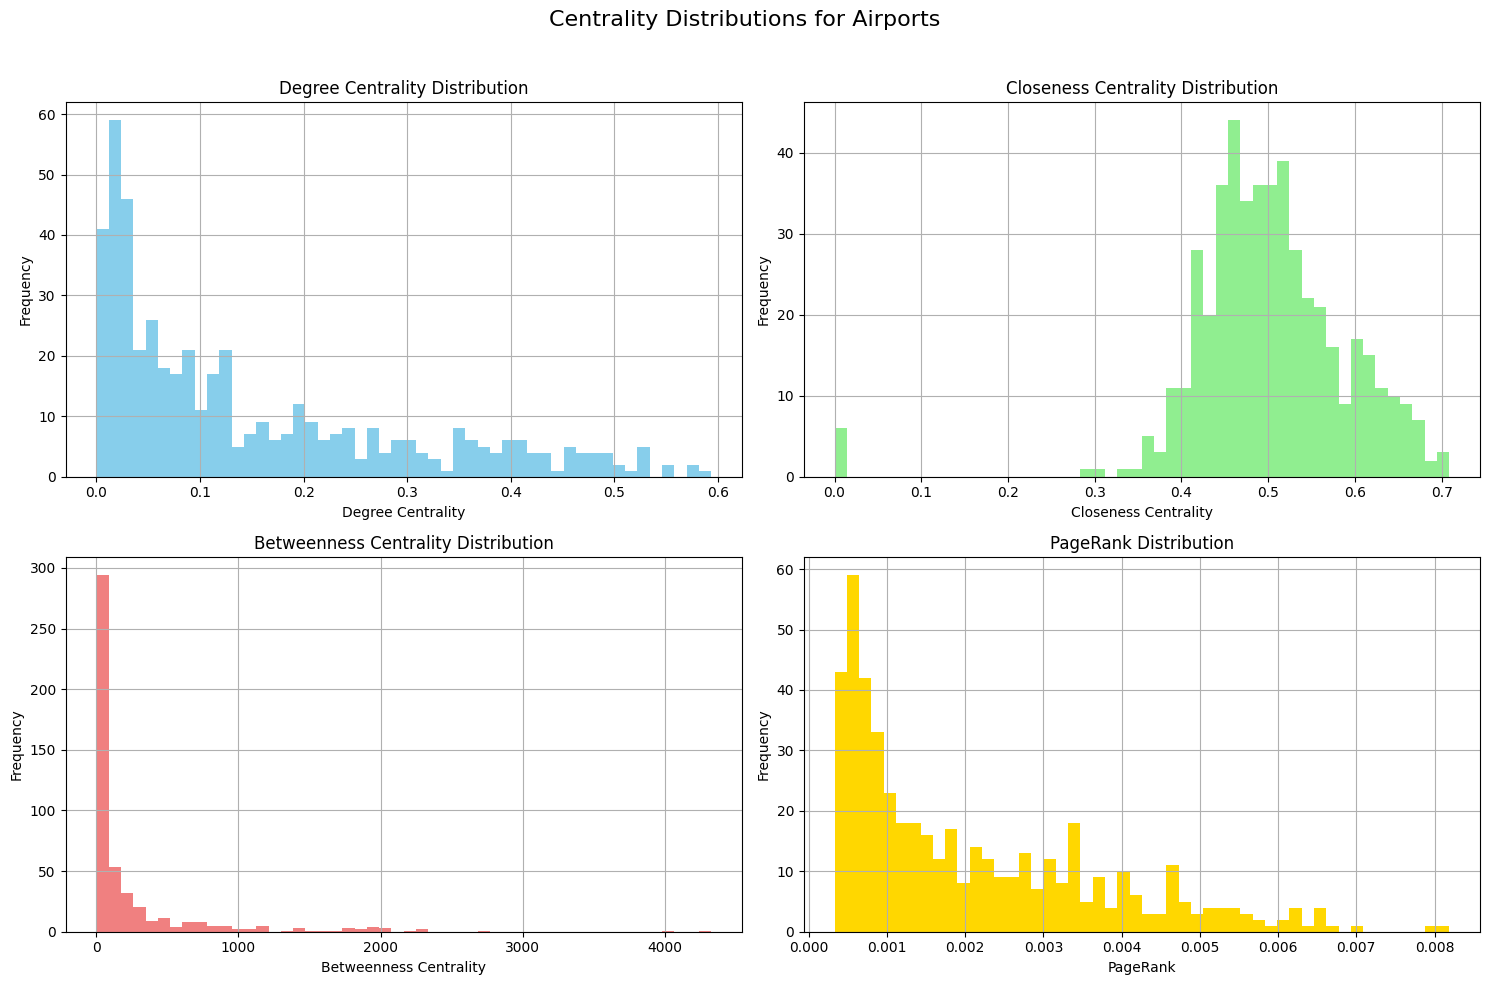

### Top Degree Centrality

| Airport   |   Degree Centrality |
|:----------|--------------------:|
| MSP       |            0.593361 |
| YIP       |            0.578838 |
| ORD       |            0.574689 |
| ATL       |            0.551867 |
| MEM       |            0.547718 |

### Top Closeness Centrality

| Airport   |   Closeness Centrality |
|:----------|-----------------------:|
| MSP       |               0.708824 |
| ORD       |               0.699565 |
| YIP       |               0.698551 |
| ATL       |               0.687589 |
| MEM       |               0.68661  |

### Top Betweenness Centrality

| Airport   |   Betweenness Centrality |
|:----------|-------------------------:|
| YIP       |                  4327.52 |
| MSP       |                  3995.85 |
| PHX       |                  2739.58 |
| MIA       |                  2302.22 |
| TUS       |                  2299.1  |

### Top PageRank

| Airport   |   PageRank |
|:----------|-----------:|
| MSP       | 0.00818836 |
| YIP       | 0.00799235 |
| MEM       | 0.0070689  |
| STL       | 0.00666363 |
| MCI       | 0.00660087 |

In [32]:
compare_centralities(graph)

`MSP (Minneapolis-Saint Paul)` has the highest degree centrality (0.593361), indicating it has the largest number of direct connections; ranks highest (0.708824) for closeness centrality, which measures how efficiently an airport can reach all other airports in the network; and again holds the highest pagerank (0.00818836), reinforcing its importance not only as a well-connected node but also as a hub connected to other highly influential nodes.

`YIP (Willow Run)` has a strong importance in terms of degree centrality (0.5788,the direct connectivity); dominates betweenness centrality (4327.52), meaning it acts as a major bridge for traffic between other airports; and is also significant in terms of influence within the network, with a pagerank of 0.00799235.

In summary:


-`MSP`emerges as the most important airport overall, leading across multiple centrality measures.

-`YIP`plays a critical bridging role, as indicated by its high betweenness centrality.

-`ORD, ATL, and MEM` are versatile nodes, demonstrating both direct connectivity and influence in network access.



3. Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

here is the output of ChatGpt:
| **Centrality Measure**         | **Relevance**                                                | **When to Use**                          |
|--------------------------------|-------------------------------------------------------------|------------------------------------------|
| **Eigenvector Centrality**     | Importance based on connections to influential nodes.       | Identify hubs connected to other hubs.   |
| **Katz Centrality**            | Balances influence of hubs and smaller nodes.               | Highlight strategic regional airports.   |
| **Harmonic Centrality**        | Accounts for disconnected nodes.                            | Sparse or disconnected networks.         |
| **Load Centrality**            | Measures flow through nodes.                                | Critical intermediaries for traffic.     |
| **Clustering Coefficient**     | Tendency to form local, tight clusters.                     | Identify regional clusters of routes.    |
| **Edge Betweenness Centrality**| Identifies critical edges in the network.                   | Find key flight routes.                  |
| **Strength Centrality**        | Weighted degree: accounts for passenger/traffic volume.     | Identify traffic-heavy airports.         |


to check his reliability we can check with a correlation methods to compare the centrality scores

4. Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

In [30]:
import networkx as nx
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

def calculate_alternative_centralities(flight_network):
    """
    Calculate Degree Centrality and Eigenvector Centrality for a given graph.
    Returns a DataFrame with centrality measures.
    """
    # Degree Centrality
    degree_centrality = nx.degree_centrality(flight_network)

    # Eigenvector Centrality
    eigenvector_centrality = nx.eigenvector_centrality(flight_network, weight='weight')

    # Create a DataFrame with centrality measures
    centrality_df2 = pd.DataFrame({
        'Airport': list(degree_centrality.keys()),
        'Degree Centrality': list(degree_centrality.values()),
        'Eigenvector Centrality': [eigenvector_centrality[node] for node in degree_centrality]
    })

    return centrality_df2

def plot_centrality_distributions(centrality_df):
    """
    Plot the distributions of Degree Centrality and Eigenvector Centrality.
    """
    plt.figure(figsize=(12, 5))

    # Degree Centrality Histogram
    plt.subplot(1, 2, 1)
    plt.hist(centrality_df['Degree Centrality'], bins=30, color='skyblue')
    plt.title('Degree Centrality Distribution')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency')

    # Eigenvector Centrality Histogram
    plt.subplot(1, 2, 2)
    plt.hist(centrality_df['Eigenvector Centrality'], bins=30, color='lightcoral')
    plt.title('Eigenvector Centrality Distribution')
    plt.xlabel('Eigenvector Centrality')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [33]:
centrality_df2=calculate_alternative_centralities(graph)

In [25]:
def test_centrality_correlation(centrality_df):
    degree = centrality_df['Degree Centrality']
    eigenvector = centrality_df['Eigenvector Centrality']

    #Spearman's rank correlation
    correlation, p_value = spearmanr(degree, eigenvector)

    print("Spearman's Rank Correlation between Degree and Eigenvector Centrality:")
    print(f"Correlation Coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4e}")

    return correlation, p_value

In [34]:
test_centrality_correlation(centrality_df2)

Spearman's Rank Correlation between Degree and Eigenvector Centrality:
Correlation Coefficient: 0.9552
P-value: 1.9173e-256


(np.float64(0.9551831531163336), np.float64(1.9172640537759008e-256))

because the correlation coefficient its high (its maximum its 1) we can consider his output trustable

____
## **Finding Best Routes (Q3)**

- In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.

**Note**: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city A has airports $a_1$ , $a_2$ and city B has $b_1$ , $b_2$ , the function should compute the best routes for $a_1 → b_1$ , $a_1 → b_2$ , $a_2 → b_1$ and $a_2 → b_2$ . If it’s not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:

1. Flights network

2. Origin city name

3. Destination city name

4. Considered Date (in yyyy-mm-dd format)

The function output:

1. A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.

**Note**: In the "Best_route" column, we expect a list of airport names connected by → , showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."


> We choose the date with the most flights in the dataset

In [45]:
Date = df.groupby('Fly_date')['Origin_airport'].count().idxmax()
Date

'2007-12-01'

> After debug and analyzing our `distances_dictionary` from *Seattle*, we choose one of the routes with the highest `best_distance` in order to highlight the sequence of flights that brings to the destination. 

In [46]:
Origin_city = "Seattle"
Destination_city = "Bloomington"

> To compute the best route we can use the **Dijkstra's algorithm**.

#### **Dijkstra's algorithm**


Here it is a pseudocode:

```python

1. Initialize a priority queue (min-heap) called 'pq'

2. For each node in the graph:

    a. Set the distance to the source node as 0

    b. Set the distance to all other nodes as infinity

    c. Set the previous node for all nodes as undefined (None)

3. Insert the source node into the priority queue with distance 0

4. While the priority queue 'pq' is not empty:

    - Pop the node 'current' with the smallest distance from 'pq'

    - For each neighbor of the current node:

        - Calculate the new distance to the neighbor: new_distance = current_distance + edge_weight
        
        - If the new distance is smaller than the current known distance to the neighbor:

            - Update the shortest distance to this neighbor

            - Set the previous node to the current node

            - Insert the neighbor into the priority queue with the updated distance

5. After all nodes are processed, the algorithm ends.

6. The shortest path from the source to any node can be reconstructed by following the previous nodes.


**Function** `compute_best_route(graph, origin, destination, date)`

The Function `compute_best_route` computes the best route in a specific date between two cities.

- The graph is filtered using `filter_graph_by_date` function that creates a new graph adding only the edges relative to the input date

- Then we iterate over the all the pairs between the airports in the source and destination cities and minimize the distance between them using the `compute_Dijkstra` function. Since the Dijkstra algorithm computes a dictionary of distances from the minimized sources, we can apply it only once and then iterate over the number of airports in the destination city indexing in the `distances_dict`

- If the distance computed is less than the best_distance so update it and apply the `reconstruct_path` function where it builds the path to reach the destination iterating over the `prev` dictionary

- We return a Dataframe with all the infos needed

In [47]:
table = functions.compute_best_route(graph, Origin_city, Destination_city, Date)

# To hide the index of the row (only row of the dataframe)
table.style.hide(axis="index")

Origin_city_airport,Destination_city_airport,Best_route
Seattle,Bloomington,BFI->JFK->TCL->BDL->PWM->AVP->BMI


## **Airline Network Partitioning (Q4)**

- In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.

## **Finding and Extracting Communities (Q5)**

1. In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.

Based ong the function created in Q1:

**Function** `create_airport_graph`

Our goal is to analyze communities through a function that takes in the flight network and two cities name, and outputs the total number of communities, has to visualize the graph highlighting the communities with different colors and tell if the two cities are within the same commnunity.

To do this we are going to use Louvain algorithm, which is more suitable for a complex graph, like the one we are analyzing

### Function: `modularity`

This function calculates the **modularity** of a partition in a graph, which is a measure of the strength of division of a network into communities. A higher modularity score indicates a stronger division of the network into well-defined communities. The function works for undirected graphs and takes into account the edge weights.

#### Parameters:
- **G** (`networkx.Graph`): An object representing the network.
  - The weights of the edges represent the strength of the connection between nodes, in this case the distance between the airports
  
- **partition** (`dict`): A dictionary where:
  - **Key**: Node (representation of an airport).
  - **Value**: The community number that the node belongs to.

#### Returns:
- **float**: The modularity score of the given partition. A higher modularity score indicates better community structure.

#### Algorithm:
1. **Degree Calculation**: The degree of each node is computed based on the weights of the edges.
2. **Community Structure**: The nodes are grouped into their respective communities as per the `partition` dictionary.
3. **Modularity Formula**:

  $$ Q = \frac{1}{2m} \sum_{c} \left( \sum_{i,j \in c} A_{ij} - \frac{d_i d_j}{2m} \right) $$

&nbsp;&nbsp;&nbsp;&nbsp;where:  
&nbsp;&nbsp;&nbsp;&nbsp;- $A_{ij}$ is the edge weight between nodes $i$ and $j$  
&nbsp;&nbsp;&nbsp;&nbsp;- $d_i, d_j$ are degrees of nodes $i$ and $j$  
&nbsp;&nbsp;&nbsp;&nbsp;- $m$ is total edge weight in the graph  
&nbsp;&nbsp;&nbsp;&nbsp;- sum over all node pairs in community $c$


In [11]:
def modularity(G, partition):
    m = G.size(weight='weight')
    degrees = dict(G.degree(weight='weight'))
    communities = {}
    
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)
    
    q = 0
    for community, nodes in communities.items():
        l_c = sum([G[u][v]['weight'] for u in nodes for v in nodes if G.has_edge(u, v)])
        d_c = sum([degrees[node] for node in nodes])
        q += l_c / (2 * m) - (d_c / (2 * m))**2
    
    return q


### Function: `louvain_method`

It is an algorithm that finds communities optimizing modularity.

1. **How does it work?**
   - Iterates through each node
   - Tests moving node to neighboring communities
   - Calculates modularity change for each potential move  
   - Selects move giving highest modularity increase
   - Repeats until no moves improve modularity

2. **Implementation**
   - Initial state: each node in separate community
   - `move_node()`: handles single iteration of node movements
   - Main loop continues until no further improvements possible
   - Returns final community assignments as dictionary

In [12]:
def louvain_method(G):
    def move_node(G, partition):
        moved = False
        for node in G.nodes():
            best_community = partition[node]
            best_increase = 0
            for neighbor in G.neighbors(node):
                community = partition[neighbor]
                if community == partition[node]:
                    continue
                original_modularity = modularity(G, partition)
                partition[node] = community
                new_modularity = modularity(G, partition)
                increase = new_modularity - original_modularity
                if increase > best_increase:
                    best_community = community
                    best_increase = increase
                partition[node] = best_community
            if best_community != partition[node]:
                partition[node] = best_community
                moved = True
        return moved

    partition = {node: i for i, node in enumerate(G.nodes())}
    while True:
        if not move_node(G, partition):
            break

    return partition

### Function `analyze_flight_network_louvain_fs`

Main function to apply the algorithm.

**Steps**
1. Community detection
2. Checking if the two cities given as input are part of the same community
3. Creates a Folium map to represent the communities, dividing them by color

In [13]:
import folium

def analyze_flight_network_louvain_fs(G, city1, city2):

    G_undirected = G.to_undirected()

    partition = louvain_method(G_undirected)
    
    num_communities = len(set(partition.values()))

    communities = {}
    for node, community in partition.items():
        communities.setdefault(community, []).append(node)
    
    city1_community = None
    city2_community = None
    
    for community, nodes in communities.items():
        community_cities = {G.nodes[node]['city'] for node in nodes}
        if city1 in community_cities:
            city1_community = community
        if city2 in community_cities:
            city2_community = community

    same_community = (city1_community == city2_community)

    map_center = [df['Org_airport_lat'].mean(), df['Org_airport_long'].mean()]
    m = folium.Map(location=map_center, zoom_start=5)

    np.random.seed(0)
    colors = np.random.randint(0, 256, size=(num_communities, 3))
    colors = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

    for community, nodes in communities.items():
        for node in nodes:
            lat = G.nodes[node]['lat']
            long = G.nodes[node]['long']
            city = G.nodes[node]['city']
            folium.CircleMarker(
                location=[lat, long],
                radius=5,
                color=colors[community % len(colors)],
                fill=True,
                fill_color=colors[community % len(colors)],
                fill_opacity=0.6,
                popup=city
            ).add_to(m)

    '''
    for u, v, data in G.edges(data=True):
        origin_lat = G.nodes[u]['lat']
        origin_long = G.nodes[u]['long']
        dest_lat = G.nodes[v]['lat']
        dest_long = G.nodes[v]['long']
        folium.PolyLine(
            locations=[(origin_lat, origin_long), (dest_lat, dest_long)],
            color='gray',
            weight=1,
            opacity=0.5
        ).add_to(m)'''

    return num_communities, communities, same_community, m


In [15]:
num_communities, communities, same_community, map = analyze_flight_network_louvain_fs(graph.copy(), 'Sacramento, CA', 'Los Angeles. CA')
print(f"Number of communities: {num_communities}")
print(f"Communities: {communities}")
print(f"Do City1 and City2 belong to the same community? {same_community}")
map.save("./assets/flight_network_map_louvain.html")

Number of communities: 38
Communities: {171: ['EUG', 'YKM', 'CLM', 'PUW', 'GGG', 'GTF', 'FAT', 'TUS', 'MWH', 'BIL', 'DFW', 'CPR', 'ANC', 'AZA', 'IAH', 'TUL', 'OMA', 'PIA', 'GJT', 'CYS', 'ABR', 'ROW', 'BIS', 'FCA', 'BLI', 'DSM', 'GFK', 'BFL', 'SGF', 'FSD', 'BTR', 'IDA', 'ORD', 'YUM', 'MOT', 'BNA', 'IND', 'TWF', 'MTJ', 'DTW', 'CVG', 'JAC', 'FWA', 'HOU', 'RKS', 'PIH', 'ATL', 'EWR', 'JFK', 'MDT', 'IAD', 'MHT', 'FAI', 'JLN', 'OGG', 'ILN', 'HMN', 'POB', 'LAF', 'NKX', 'LSV', 'EIL', 'JMS', 'PFN', 'EWN', 'NQX', 'PIB', 'MIE', 'SSC', 'TMB', 'BFM', 'HIF', 'MIB', 'ISN', 'OGD', 'SGU', 'MUO', 'PVU', 'NZY', 'MDH', 'ANB', 'IMT', 'MGY', 'ADQ', 'ALW', 'VAD', 'TIW', 'VEL', 'OLM', 'MGW', 'HSH', 'LAM'], 60: ['RDM', 'RDD', 'FBK', 'SAF', 'FSM', 'DLH', 'HLN', 'AUS', 'MSO', 'SBA', 'ITH', 'ROA', 'BTV', 'TYS', 'HVR', 'APF', 'HVN', 'MRI'], 371: ['MFR', 'PDX', 'EAT', 'FOE', 'COS', 'RFD', 'SAT', 'CID', 'SPI', 'BZN', 'SBN', 'GRK', 'BOS', 'SYR', 'MCO', 'LAN', 'BWG', 'GPT', 'KTN', 'RIV', 'SAV', 'FLG', 'FFO', 'TCM', 'SB

2. Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.

**LLM suggestion**

An alternative method, suggested by ChatGPT, for community detection is the **Label Propagation Algorithm**. 

This algorithm works with the following procedure:
1. Initialization: assigning a unique label to each node in the network --> This step uses the function created in QA1 to create the graph
2. Label Propagation: the label of each node gets updated based on the most frequent label among its neighbors.
3. Convergence: label propagation is repeated unitl the label no longer change or a maximum number of iterations is reached

### Label Propagation Algorithm

In [16]:
from collections import Counter
import random

def label_prop(Graph, max_iter=100, tol=0.1):
    nodes = list(Graph.nodes())
    labels = {node: i for i, node in enumerate(nodes)}
    
    iter_count = 0
    stabilized = False
    
    while not stabilized and iter_count < max_iter:
        iter_count += 1
        old_labels = labels.copy()
        random.shuffle(nodes)
        
        for node in nodes:
            if not list(Graph.neighbors(node)):
                continue
                
            # Weight labels by edge weights if available
            neighbor_labels = []
            for neighbor in Graph.neighbors(node):
                weight = Graph[node][neighbor].get('weight', 1.0)
                neighbor_labels.extend([labels[neighbor]] * int(weight * 10))
            
            if neighbor_labels:
                # Get top 3 most common labels
                most_common = Counter(neighbor_labels).most_common(1)
                # Randomly select from top labels with preference to more common ones
                weights = [count for _, count in most_common]
                new_label = random.choices([label for label, _ in most_common], 
                                        weights=weights)[0]
                labels[node] = new_label
    
    return labels

#### Analysis using LPA

In [17]:
def analyze_flight_network_lpa(Graph, city1, city2):

    G_undirected = Graph.to_undirected()

    for u, v in G_undirected.edges():
        lat1, lon1 = G_undirected.nodes[u]['lat'], G_undirected.nodes[u]['long']
        lat2, lon2 = G_undirected.nodes[v]['lat'], G_undirected.nodes[v]['long']
        dist = np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)
        G_undirected[u][v]['weight'] = 1 / (1 + dist)

    partition = label_prop(G_undirected)

    num_communities = len(set(partition.values()))

    communities = {}
    for node, community in partition.items():
        if community not in communities:
            communities[community] = []
        communities[community].append(node)

    city1_community = None
    city2_community = None

    for community, nodes in communities.items():
        community_cities = {Graph.nodes[node]['city'] for node in nodes}
        if city1 in community_cities:
            city1_community = community
        if city2 in community_cities:
            city2_community = community
    
    same_community = (city1_community == city2_community)

    map_center = [
        np.mean([Graph.nodes[node]['lat'] for node in Graph.nodes()]),
        np.mean([Graph.nodes[node]['long'] for node in Graph.nodes()])
    ]
    map = folium.Map(location=map_center, zoom_start=5)

    np.random.seed(0)
    colors = np.random.randint(0, 256, size=(num_communities, 3))
    colors = [f'#{r:02x}{g:02x}{b:02x}' for r, g, b in colors]

    '''
    for (u, v) in G_undirected.edges():
        coords = [(Graph.nodes[u]['lat'], Graph.nodes[u]['long']),
                 (Graph.nodes[v]['lat'], Graph.nodes[v]['long'])]
        folium.PolyLine(coords, weight=1, color='blue', opacity=0.1).add_to(map)'''

    for community, nodes in communities.items():
        for node in nodes:
            lat = Graph.nodes[node]['lat']
            long = Graph.nodes[node]['long']
            city = Graph.nodes[node]['city']
            folium.CircleMarker(
                location=[lat, long],
                radius=5,
                color=colors[community % len(colors)],
                fill_opacity=0.6,
                popup=city
            ).add_to(map)
    
    return num_communities, communities, same_community, map

In [18]:
num_communities, communities, same_community, map_lpa = analyze_flight_network_lpa(graph.copy(), 'Sacramento, CA', 'Chicago, IL')
print(f"Number of communities: {num_communities}")
print(f"Communities: {communities}")
print(f"Do City1 and City2 belong to the same community? {same_community}")

map_lpa.save("flight_network_map_lpa.html")

Number of communities: 16
Communities: {3: ['EUG', 'RDM', 'MFR', 'SEA', 'PDX', 'LMT', 'EAT', 'YKM', 'SLE', 'GEG', 'LWS', 'AST', 'CLM', 'PDT', 'PUW', 'BFI', 'MWH', 'MSO', 'FCA', 'BLI', 'TCM', 'CVO', 'ALW', 'SKA', 'OLM', 'LGD', 'SFF'], 6: ['SFO', 'RDD', 'SJC', 'ACV', 'SMF', 'RNO', 'CIC', 'CEC', 'STS', 'OAK', 'MOD', 'SCK', 'MCE', 'APC', 'MHR', 'EKA', 'UKI', 'MCC', 'SNS'], 7: ['LAX', 'PHX', 'FAT', 'TUS', 'LAS', 'AZA', 'SAN', 'BFL', 'SBA', 'YUM', 'VGT', 'CDC', 'SNA', 'RIV', 'FLG', 'HMN', 'DMA', 'HII', 'IPL', 'SBP', 'NKX', 'LUF', 'LSV', 'NJK', 'SDM', 'SGU', 'MUO', 'NZY', 'OLS', 'BIH', 'OXR', 'VIS', 'SOW', 'MAE', 'SAC', 'PRC', 'DVT', 'SEE', 'HSH'], 323: ['EKO', 'GTF', 'BIL', 'SLC', 'CPR', 'SAF', 'ABQ', 'DRO', 'HLN', 'BTM', 'PUB', 'COS', 'GJT', 'CYS', 'GCC', 'RAP', 'BFF', 'IDA', 'BZN', 'MOT', 'TWF', 'MTJ', 'JAC', 'RKS', 'PIH', 'RIW', 'SHR', 'LGU', 'RCA', 'LAR', 'HVR', 'FMN', 'HIF', 'MIB', 'ISN', 'DIK', 'OGD', 'PUC', 'PVU', 'GUP', 'VEL', 'LAM'], 210: ['FLL', 'GGG', 'FSM', 'ICT', 'DLH', 'OKC', '

#### **Result comparison**
It is possible to see differences in the number of communities the two algorithms are able to identify; **Louvain algorithm** was able to identify 38 communities, while **Label Propagation** just 16.
Time complexity is sensibly lower in Label Propagation Algorithm.
<br><br>
Visually, the map generated using the **Label Propagation Algorithm** seems to identify communities close to each other; while Louvain seems able to identify communities where nodes are not close to each other.
<br><br>
In my opinion Louvain is better because of its ability to identify connections where nodes are not actually close to each other, that might exist in dividing the graph, based on how the edges are formed.

## **Bonus Question - Connected Components on MapReduce**

1. In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

2. Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.

## **Algorithmic Question (AQ)**

Arya needs to travel between cities using a network of flights. Each flight has a fixed cost (in euros), and she wants to find the cheapest possible way to travel from her starting city to her destination city. However, there are some constraints on the journey:

- Arya can make at most `k` stops during her trip (this means up to `k+1` flights).
    
- If no valid route exists within these constraints, the result should be `-1`.

Given a graph of cities connected by flights, your job is to find the minimum cost for Arya to travel between two specified cities (`src` to `dst`) while following the constraints.

**a)** Write a pseudocode that describes the algorithm to find the cheapest route with at most k stops.

```
Function findCheapestPrice(n, flights, src, dst, k):
    # Input:
    # n: number of cities (0 to n-1)
    # flights: list of edges [from, to, cost]
    # src: starting city
    # dst: destination city
    # k: maximum number of stops allowed

    # Represent the graph as an adjacency list
    graph = Create an empty adjacency list for n cities
    For each flight in flights:
        Add an edge from flight[0] to flight[1] with cost flight[2]

    # Initialize the priority queue (min-heap)
    # Priority queue will store tuples in the form: (current_cost, current_city, stops_used)
    pq = MinHeap()
    pq.push((0, src, 0))  # Start with cost 0, starting city, and 0 stops

    # Initialize a visited dictionary to track the minimum cost to each city with at most x stops
    visited = Dictionary with default value of Infinity
    visited[(src, 0)] = 0

    # Perform BFS/Modified Dijkstra
    While pq is not empty:
        (current_cost, current_city, stops_used) = pq.pop()

        # If destination is reached, return the cost
        If current_city == dst:
            Return current_cost

        # If the number of stops exceeds k, skip processing further
        If stops_used > k:
            Continue

        # Explore neighbors
        For each neighbor in graph[current_city]:
            next_city = neighbor[0]
            flight_cost = neighbor[1]
            new_cost = current_cost + flight_cost

            # Check if this route is better than previously known costs
            If new_cost < visited.get((next_city, stops_used + 1), Infinity):
                visited[(next_city, stops_used + 1)] = new_cost
                pq.push((new_cost, next_city, stops_used + 1))

    # If destination not reachable within k stops, return -1
    Return -1
```

**b)** Implement the algorithm in Python and simulate the given test cases.

In [12]:
import heapq
from collections import defaultdict

def findCheapestPrice(n, flights, src, dst, k):
    # Represent the graph as an adjacency list
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))

    # Initialize the priority queue (min-heap)
    # Priority queue stores tuples in the form (current_cost, current_city, stops_used)
    pq = [(0, src, 0)]  # (cost, node, stops)

    # Initialize visited dictionary
    visited = {}  # Key: (city, stops), Value: minimum cost

    # Perform the modified Dijkstra's/BFS
    while pq:
        current_cost, current_city, stops_used = heapq.heappop(pq)

        # If destination is reached, return the cost
        if current_city == dst:
            return current_cost

        # If stops used exceeds the limit, continue
        if stops_used > k:
            continue

        # Explore neighbors
        for neighbor, flight_cost in graph[current_city]:
            new_cost = current_cost + flight_cost

            # Only process if this route is cheaper than previously known costs
            if (neighbor, stops_used + 1) not in visited or new_cost < visited[(neighbor, stops_used + 1)]:
                visited[(neighbor, stops_used + 1)] = new_cost
                heapq.heappush(pq, (new_cost, neighbor, stops_used + 1))

    # If destination is not reachable within k stops, return -1
    return -1

# Test cases
print(findCheapestPrice(4, [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]], 0, 3, 1))
print(findCheapestPrice(3, [[0, 1, 100], [1, 2, 100], [0, 2, 500]], 0, 2, 1))
print(findCheapestPrice(3, [[0, 1, 100], [1, 2, 100], [0, 2, 500]], 0, 2, 0))
print(findCheapestPrice(4, [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]], 0, 3, 2))
print(findCheapestPrice(4, [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]], 0, 3, 2))

700
200
500
400
400


**c)** Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., `n > 100`).

#### Time Complexity

The time complexity can be analyzed based on the following factors:

- **Building the Graph**:
  - The adjacency list is built by iterating through the `flights` list.
  - Time complexity: `O(E)`, where `E` is the number of edges (flights).

- **Heap Operations**:
  - In the worst case, each node `V` can be pushed into and popped from the heap multiple times (up to `k + 1` stops).
  - Each heap operation (push/pop) takes `O(log V)`, where `V` is the number of vertices (cities).

- **Iterating Over Neighbors**:
  - For each node, the algorithm iterates over its neighbors, which collectively across all nodes is `O(E)`, where `E` is the number of edges.

Overall, the total time complexity is:
$$
O(E + (V + kE) * log V)
$$

For sparse graphs (E ≈ V), this simplifies to:
$$
O((k + 1) * V * log V)
$$

---

#### Space Complexity

- **Graph Storage**:
  - The adjacency list requires \(O(V + E)\) space.
- **Heap Storage**:
  - The heap can grow to at most \(O(V)\) entries at a time.
- **Visited Dictionary**:
  - Stores at most \(O(V)\) entries for all cities.

Overall space complexity:
$$
O(V + E)
$$

---

#### Efficiency for Large Graphs

- For large graphs with \(n > 100\) (e.g., $n = 10^4$), the algorithm may remain efficient if \(k\) (the number of allowed stops) is small, as the heap operations dominate the complexity.
- However, for dense graphs where $E \approx V^2$, the performance could degrade significantly due to the $O(E)$ factor.

**d)** Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.

```
function find_cheapest_price(n, flights, src, dst, k):
    # Build the adjacency list for forward and backward graphs
    forward_graph = defaultdict(list)
    backward_graph = defaultdict(list)
    for u, v, cost in flights:
        forward_graph[u].append((v, cost))
        backward_graph[v].append((u, cost))
    
    # Initialize min-heaps for forward and backward searches
    forward_heap = [(0, src, 0)]  # (cost, current_city, stops)
    backward_heap = [(0, dst, 0)]  # (cost, current_city, stops)
    
    # Initialize visited dictionaries for both directions
    forward_visited = {}
    backward_visited = {}

    # Track minimum cost across both searches
    min_cost = float('inf')
    
    # Perform the bidirectional search
    while forward_heap or backward_heap:
        # Process forward search
        if forward_heap:
            forward_cost, forward_city, forward_stops = heapq.heappop(forward_heap)
            
            # Update visited for forward search
            if forward_city in forward_visited and forward_visited[forward_city] <= forward_stops:
                continue
            forward_visited[forward_city] = forward_stops
            
            # Check for connection with backward search
            if forward_city in backward_visited:
                total_stops = forward_stops + backward_visited[forward_city] - 1
                if total_stops <= k:
                    min_cost = min(min_cost, forward_cost + backward_visited[forward_city])
            
            # Add neighbors to forward heap
            if forward_stops <= k:
                for neighbor, cost in forward_graph[forward_city]:
                    heapq.heappush(forward_heap, (forward_cost + cost, neighbor, forward_stops + 1))
        
        # Process backward search
        if backward_heap:
            backward_cost, backward_city, backward_stops = heapq.heappop(backward_heap)
            
            # Update visited for backward search
            if backward_city in backward_visited and backward_visited[backward_city] <= backward_stops:
                continue
            backward_visited[backward_city] = backward_stops
            
            # Check for connection with forward search
            if backward_city in forward_visited:
                total_stops = forward_visited[backward_city] + backward_stops - 1
                if total_stops <= k:
                    min_cost = min(min_cost, backward_cost + forward_visited[backward_city])
            
            # Add neighbors to backward heap
            if backward_stops <= k:
                for neighbor, cost in backward_graph[backward_city]:
                    heapq.heappush(backward_heap, (backward_cost + cost, neighbor, backward_stops + 1))
    
    # Return result
    return min_cost if min_cost != float('inf') else -1
```
---

1. Bidirectional Search:

- Instead of searching the entire graph from one direction, simultaneously search from both the source and the destination.
- Reduces the number of nodes explored, especially for large graphs.

2. Pruning:

- Terminate searches early if stops exceed the allowed $k$.
- Avoid revisiting nodes with higher or equal stops using the $visited$ dictionaries.

3. Connection Checking:

- Combine results from forward and backward searches when they meet in the middle, reducing the computation required.

---

1. Time Complexity:
- Each search (forward and backward) processes up to `(k+1) * V` heap operations.
- Each heap operation takes `O(log V)`
- Total complexity: $$ O((k + 1) * V * log V) $$

2. Space Complexity:
- Graph Storage: O(V + E) for adjacency lists.
- Heap Storage: O(V) for each heap
- Visited Dictionaries: O(V) for forward and backward searches
- Total complexity: $$ O(V + E) $$

The bidirectional search reduces the number of nodes explored, making the algorithm faster for large graphs.
By carefully pruning the search space, it avoids redundant computations, improving scalability.

**e)** Ask LLM (e.g., ChatGPT) for an optimized version of your algorithm. Compare its solution to yours in terms of performance, time complexity, and correctness.

ChatGPT responded with this: 

Here’s an optimized version of your algorithm. The main improvements involve reducing redundant exploration and avoiding unnecessary heap pushes when conditions can be pre-checked.

In [ ]:
import heapq
from collections import defaultdict

def findCheapestPath(n, flights, src, dst, k):
    # Step 1: Build the graph as an adjacency list
    graph = defaultdict(list)
    for u, v, cost in flights:
        graph[u].append((v, cost))
    
    # Step 2: Priority queue to store (current_cost, current_city, stops)
    pq = [(0, src, 0)]  # Start with cost 0, src city, and 0 stops
    
    # Step 3: Dictionary to track the minimum cost to a city with a specific number of stops
    min_cost = {(src, 0): 0}
    
    # Step 4: Use Dijkstra-like traversal with constraint on stops
    while pq:
        current_cost, current_city, stops = heapq.heappop(pq)
        
        # If destination is reached, return the cost
        if current_city == dst:
            return current_cost
        
        # If stops exceed the limit, skip further processing
        if stops > k:
            continue
        
        # Expand neighbors
        for neighbor, cost in graph[current_city]:
            new_cost = current_cost + cost
            # Only push to heap if this path is cheaper than any previously found path to the neighbor
            if new_cost < min_cost.get((neighbor, stops + 1), float('inf')):
                min_cost[(neighbor, stops + 1)] = new_cost
                heapq.heappush(pq, (new_cost, neighbor, stops + 1))
    
    # If no valid path found, return -1
    return -1

## Key Differences

### 1. **Unidirectional vs. Bidirectional Search**

- **ChatGPT's Code**:
  - It uses a **unidirectional search** (Dijkstra-like approach), starting from the source city and exploring neighbors up to \(k\) stops.
- **My Optimized Code**:
  - It employs a **bidirectional search**:
    - One search starts from the source (`forward_heap`).
    - Another search starts from the destination (`backward_heap`).
    - The two searches meet in the middle, potentially reducing the number of states explored.

### 2. **Graph Representation**

- Both algorithms use an adjacency list, but my code constructs two graphs:
  - `forward_graph` for the forward search.
  - `backward_graph` for the backward search.
- ChatGPT's code only uses a single adjacency list for the forward traversal.

### 3. **Visited Tracking**

- **ChatGPT's Code**:
  - Tracks the minimum cost to reach a city with a specific number of stops using a dictionary (`min_cost`).
- **My Code**:
  - Tracks visited cities separately for forward and backward searches with their respective dictionaries (`forward_visited` and `backward_visited`).

### 4. **Meeting Criteria**

- **ChatGPT's Code**:
  - Finds the cheapest cost path when reaching the destination within \(k\) stops.
- **My Code**:
  - Merges the forward and backward results when the two searches overlap at a city, ensuring the total stops do not exceed \(k\).

---

## Pros and Cons

#### ChatGPT's Code

**Pros**:

- Simpler implementation.
- Uses fewer data structures (only one heap and one graph).

**Cons**:

- May explore redundant paths in one direction.
- Can be slower for large graphs compared to bidirectional search.

#### My Code

**Pros**:

- Bidirectional search can potentially explore fewer paths by meeting in the middle.
- Handles paths more systematically from both ends.

**Cons**:

- More complex to implement.
- Requires additional memory for two heaps, two graphs, and two visited dictionaries.